# Data selections
 - Expenditure data (GDX 2021; trailing spaces on names removed): https://www.data.va.gov/dataset/GDX-FY21/qhqa-74yq
 - Facility data: https://www.data.va.gov/dataset/PAI-Data-Set-For-Open-Data-Maps-Data-Story-1-of-3/cg9c-gfgn
 - County data: https://www.data.va.gov/dataset/VetPop2020-County-Data-9L/da7e-gv3k
                https://www.weather.gov/gis/Counties
 - State data: https://www.data.va.gov/dataset/VetPop2020-State-Data-6L/tgdn-k8nh
 - State Shape Files: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=States+%28and+equivalent%29
 - Lat/Long data: https://developers.google.com/public-data/docs/canonical/states_csv
 - Abbreviation data: https://www.stateabbreviations.us/
 - FIPS code change data: https://www2.census.gov/geo/pdfs/reference/bndrychange/new-mexico.pdf


In [1]:
# imports
import pandas as pd
import os
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from geopy.geocoders import Nominatim
#from geopy.point import Point
from shapely.geometry import Point
from simpledbf import Dbf5
#from mpl_toolkits.basemap import Basemap
import contextily as ctx 
#os.chdir('C:/Users/brian/Documents/Practicum Data')

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [2]:
# Calculate preferred ratio; identify states that do not require facility addition or closure
expenditures = pd.read_excel('py_expenditures.xlsx', usecols =['state', 'expenditure'])
total_expenditures = expenditures['expenditure'].sum()
expenditures['percent of total'] = (expenditures['expenditure'] / total_expenditures) * 100
top_states = expenditures.sort_values(by = ['percent of total'], ascending = False).iloc[0:5, 0]

In [ ]:
# Reverse geocode from latitude and longtigude to get state facility totals

# The following code can be used to reverse geocode the state name from lat / long data
# Nominatim has a limited number of requests allowed, thus this code is commented out and the extracted data is pulled in from an excel file into facility_totals in the block below

#facilities = pd.read_excel('py_facilities.xlsx')
#geolocator = Nominatim(user_agent='VA-Facility-Optimization-Project')
#def reverse_geocoding(lat, lon):
    #try:
        #location = geolocator.reverse(Point(lat, lon))
        #address = location.raw['address']
        #state_name = address.get('state', '')
        #return state_name
    #except:
        #return None

#facilities['state'] = np.vectorize(reverse_geocoding)(facilities['latitude'], facilities['longitude'])

In [3]:
# Determine ratio min, max, mean for Top States (expenditures) to use as potential business problem guideline
#facility_totals = facilities.groupby('state').sum().sort_values('size', ascending = False)
#facility_totals = facility_totals.reset_index()

facility_totals = pd.read_excel('facility_totals.xlsx')
top_states = top_states.to_frame()
ratios = top_states.merge(facility_totals, on='state', how='left', indicator = True)
state_pops = pd.read_excel('py_state_totals.xlsx')
ratios['state_pop'] = state_pops['num_vets']
ratios['ratio'] = (ratios['size'] / ratios['state_pop'])
ratios = ratios.sort_values(by = ['ratio'], ascending = False)

#These lines of code can be edited to remove outlier states from analysis for a particular business problem
#ratios_reduced = ratios[ratios['state'].str.contains('North Carolina') == False]
#ratios_reduced = ratios_reduced[ratios['state'].str.contains('California') == False]
ratios_reduced = ratios

ideal_ratio_max = ratios_reduced['ratio'].max()
ideal_ratio_min = ratios_reduced['ratio'].min()
ideal_ratio_mean = ratios_reduced['ratio'].mean()

In [4]:
# Determine states that require facility addition
all_ratios = facility_totals.merge(state_pops, on='state', how='left', indicator = True)
all_ratios['ratio'] = all_ratios['size'] / all_ratios['num_vets']

# The following two lines can be edited for different business problem approaches on how to determine whether a state should require a new facility
#states_to_add = all_ratios[all_ratios['ratio'] <= ideal_ratio_max]
states_to_add = all_ratios

In [5]:
#Build Optimization model to determine best location for new facility location
# Load county centroid data
centroid_data = Dbf5('c_08mr23.dbf')
centroid_data = centroid_data.to_dataframe()

# Create new index for each state
state_abbrev = centroid_data['STATE'].unique()
state_abbrev = np.sort(state_abbrev)
data_subset = centroid_data[['STATE', 'COUNTYNAME', 'LON', 'LAT']]
state_abbrev_key = pd.read_excel('state_abbreviations.xlsx')
states_to_add = states_to_add.merge(state_abbrev_key, on = 'state', how = 'left' )
states_to_add = states_to_add.rename(columns={'abbrev': 'STATE'})
data_subset = data_subset[data_subset['STATE'].isin(states_to_add['STATE'].tolist())]


# Exclude FL, MA, MD as they will use a different optimization algorithm
unique_state_subset = data_subset[data_subset['STATE'].str.contains('FL') == False]
unique_state_subset = unique_state_subset[unique_state_subset['STATE'].str.contains('MA') == False]
unique_state_subset = unique_state_subset[unique_state_subset['STATE'].str.contains('MD') == False]

# Exclude AK & HI
unique_state_subset = unique_state_subset[unique_state_subset['STATE'].str.contains('AK') == False]
unique_state_subset = unique_state_subset[unique_state_subset['STATE'].str.contains('HI') == False]

# Excluding District of Columbia
unique_state_subset = unique_state_subset['STATE'].unique()

In [6]:
# Build map data
df = gpd.gpd.read_file('tl_2022_us_state.shp')
df = df.to_crs("EPSG:4326")
non_continental = ['AK', 'HI', 'VI','MP','GU','AS','PR']
us49 = df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

us49['ALAND_miles'] = us49['ALAND']*3.86102e-7
us49['AWATER_miles'] = us49['AWATER']*3.86102e-7

# Load county centroid data
centroid_data = Dbf5('c_08mr23.dbf')
centroid_data = centroid_data.to_dataframe()
# Create new index for each state
state_abbrev = centroid_data['STATE'].unique()
state_abbrev = np.sort(state_abbrev)
data_subset = centroid_data[['STATE', 'COUNTYNAME', 'LON', 'LAT']]

def statePlot(st,data,cmap,zoom,dpi):
    state = us49.loc[us49['STUSPS'] == st]
    state.crs = "EPSG:4326"
    f, ax = plt.subplots(1,1, figsize=(8,8), 
    sharex=True,sharey=True, dpi=dpi)
    plt.title('Map of State: ' + st,fontsize='large')
    
    plt.scatter(pts[:, 0], pts[:, 1], c = 'k', s=10)
    plt.scatter(point.x, point.y, c ='r', s=30, marker = 'D')
    ux = state.to_crs(epsg=4326).plot(data, ax=ax, edgecolor='blue', cmap=cmap, alpha = 0.2, legend=False) 
    ctx.add_basemap(ux, zoom=zoom, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.ylabel('Latitude', fontsize=12)
    plt.xlabel('Longitude', fontsize=12)
    # Use savefig to save your map
    plt.savefig('Map of State ' + str(st) +' .png')
    plt.tight_layout()
    plt.show()

#Initialize DataFrame for storing results
ofls = pd.DataFrame(columns=['state', 'LON', 'LAT'])

# Optimization Model
for abbrev in unique_state_subset:
    state = abbrev
    data_subset_trial = data_subset.loc[data_subset['STATE'] == state]
    pts = data_subset_trial[['LON', 'LAT']]
    pts = pts.to_numpy()
    POINT_NUM = len(pts)

    # New Facility Location Point
    x = cp.Variable(2)

    # Maximum Distance from a county geographical centoid to the OFL
    t = cp.Variable(1)

    # Creating constraints
    constraints = []
    for i in range(POINT_NUM):
        constraints.append(cp.norm(x-pts[i, :]) <= t)


    # Optimization model
    objective = cp.Minimize(t)
    problem = cp.Problem(objective, constraints)
    optimal_value = problem.solve()

    # Print numerical solution
    print('Optimal location for State: ' + str(state) +'= {0} '.format(x.value))

    # Display graphical solution

    point = Point(x.value[0],x.value[1])
    st = abbrev

    # The below function can be uncommented for plot output for each state
    #statePlot(st,'ALAND_miles','plasma',5,300)
    

    # Store OFLs
    ofls = ofls.append({'state' : st, 'LON' : x.value[0], 'LAT' : x.value[1]}, ignore_index = True)
 

Optimal location for State: ME= [-69.54978745  44.99768173] 
Optimal location for State: GA= [-83.59326123  32.89403905] 
Optimal location for State: CT= [-72.68809714  41.5514928 ] 
Optimal location for State: VT= [-72.54965265  43.98999514] 
Optimal location for State: NH= [-71.73853294  43.78297707] 
Optimal location for State: NY= [-75.96961855  42.23877526] 
Optimal location for State: PA= [-77.65959021  40.70260877] 
Optimal location for State: RI= [-71.4623981   41.65589621] 
Optimal location for State: VA= [-79.38784449  37.23571109] 
Optimal location for State: WV= [-80.14489763  38.72684069] 
Optimal location for State: NJ= [-74.64759709  40.13974858] 
Optimal location for State: KY= [-85.79155188  37.01156393] 
Optimal location for State: MI= [-86.18834304  44.67571408] 
Optimal location for State: MS= [-89.5380304   32.74726284] 
Optimal location for State: IA= [-93.37114864  42.63925519] 
Optimal location for State: IL= [-89.15545497  39.88139021] 
Optimal location for Sta

In [7]:
# Run additional Optimization for FL, MD, MA on a subset of state county data, as each state geography presents a boundary challenge

# Determine top 3 populated counties in each state
    # FL = Hillsborough, Duval, & Orange
    # MD - Prince George, Anne Arundel, Montgomery
    # MA - Middlesex, Worcester, Essex

# Create dataframes for optimization

fl_subset = data_subset[data_subset['STATE'].str.contains('FL') == True]
fl_subset = fl_subset[fl_subset['COUNTYNAME'].str.contains('Hillsborough|Duval|Orange', case=False, regex=True)]

md_subset = data_subset[data_subset['STATE'].str.contains('MD') == True]
md_subset = md_subset[md_subset['COUNTYNAME'].str.contains('Prince George|Anne Arundel|Montgomery', case=False, regex=True)]

ma_subset = data_subset[data_subset['STATE'].str.contains('MA') == True]
ma_subset = ma_subset[ma_subset['COUNTYNAME'].str.contains('Middlesex|Worcester|Essex', case=False, regex=True)]

edge_states = pd.concat([fl_subset, md_subset, ma_subset])
edge_states_abbrev = edge_states['STATE'].unique()


# Optimization Model
for abbrev in edge_states_abbrev:
    state = abbrev
    data_subset_trial = edge_states.loc[data_subset['STATE'] == state]
    pts = data_subset_trial[['LON', 'LAT']]
    pts = pts.to_numpy()
    POINT_NUM = len(pts)

    # New Facility Location Point
    x = cp.Variable(2)

    # Maximum Distance from a county geographical centoid to the OFL
    t = cp.Variable(1)

    # Creating constraints
    constraints = []
    for i in range(POINT_NUM):
        constraints.append(cp.norm(x-pts[i, :]) <= t)

    # Need to incorporate linear constraint such that OFL is within state boundaries for edge case states

    # Optimization model
    objective = cp.Minimize(t)
    problem = cp.Problem(objective, constraints)
    optimal_value = problem.solve()

    # Print numerical solution
    print('Optimal location for State: ' + str(state) +'= {0} '.format(x.value))

    point = Point(x.value[0],x.value[1])
    st = abbrev

    # The below function can be uncommented for plot output for each state
    #statePlot(st,'ALAND_miles','plasma',5,300)

    ofls = ofls.append({'state' : st, 'LON' : x.value[0], 'LAT' : x.value[1]}, ignore_index = True)
    
# Export OFLs for integration into Tableau
##ofls.to_excel("ofls.xlsx")

Optimal location for State: FL= [-82.04428354  29.05439522] 
Optimal location for State: MD= [-76.86887354  39.02518284] 
Optimal location for State: MA= [-71.43290485  42.51216432] 


In [54]:
# Plot US States and OFLs
state_pops_reduced = state_pops[state_pops['state'].str.contains('Alaska') == False]
state_pops_reduced = state_pops_reduced[state_pops_reduced['state'].str.contains('Hawaii') == False]
state_pops_reduced = state_pops_reduced[state_pops_reduced['state'].str.contains('Puerto Rico') == False]

us49['num_vets'] = state_pops_reduced['num_vets'] * 3.86102e-7
data=us49['num_vets']
cmap='twilight'
zoom=6
dpi=200

ofls_reduced = pd.DataFrame(columns=['LON', 'LAT'])
ofls_reduced['LON'] = ofls['LON']
ofls_reduced['LAT'] = ofls['LAT']


# Convert resulting OFL coordinates from espg:4326 to espg:3857
ofls_transformed = pd.DataFrame(columns=['LON', 'LAT'])

from pyproj import Proj, transform

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')

x = ofls_reduced['LON']
y = ofls_reduced['LAT']
x2,y2 = transform(inProj,outProj,x,y)
    #ofls_transformed.append({'LON' : x2.value, 'LAT' : y2.value}, ignore_index = True)
ofls_reduced['LON'] = x2
ofls_reduced['LAT'] = y2

c:\Users\brian\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\brian\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\brian\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.githu

c:\Users\brian\AppData\Local\Programs\Python\Python37\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


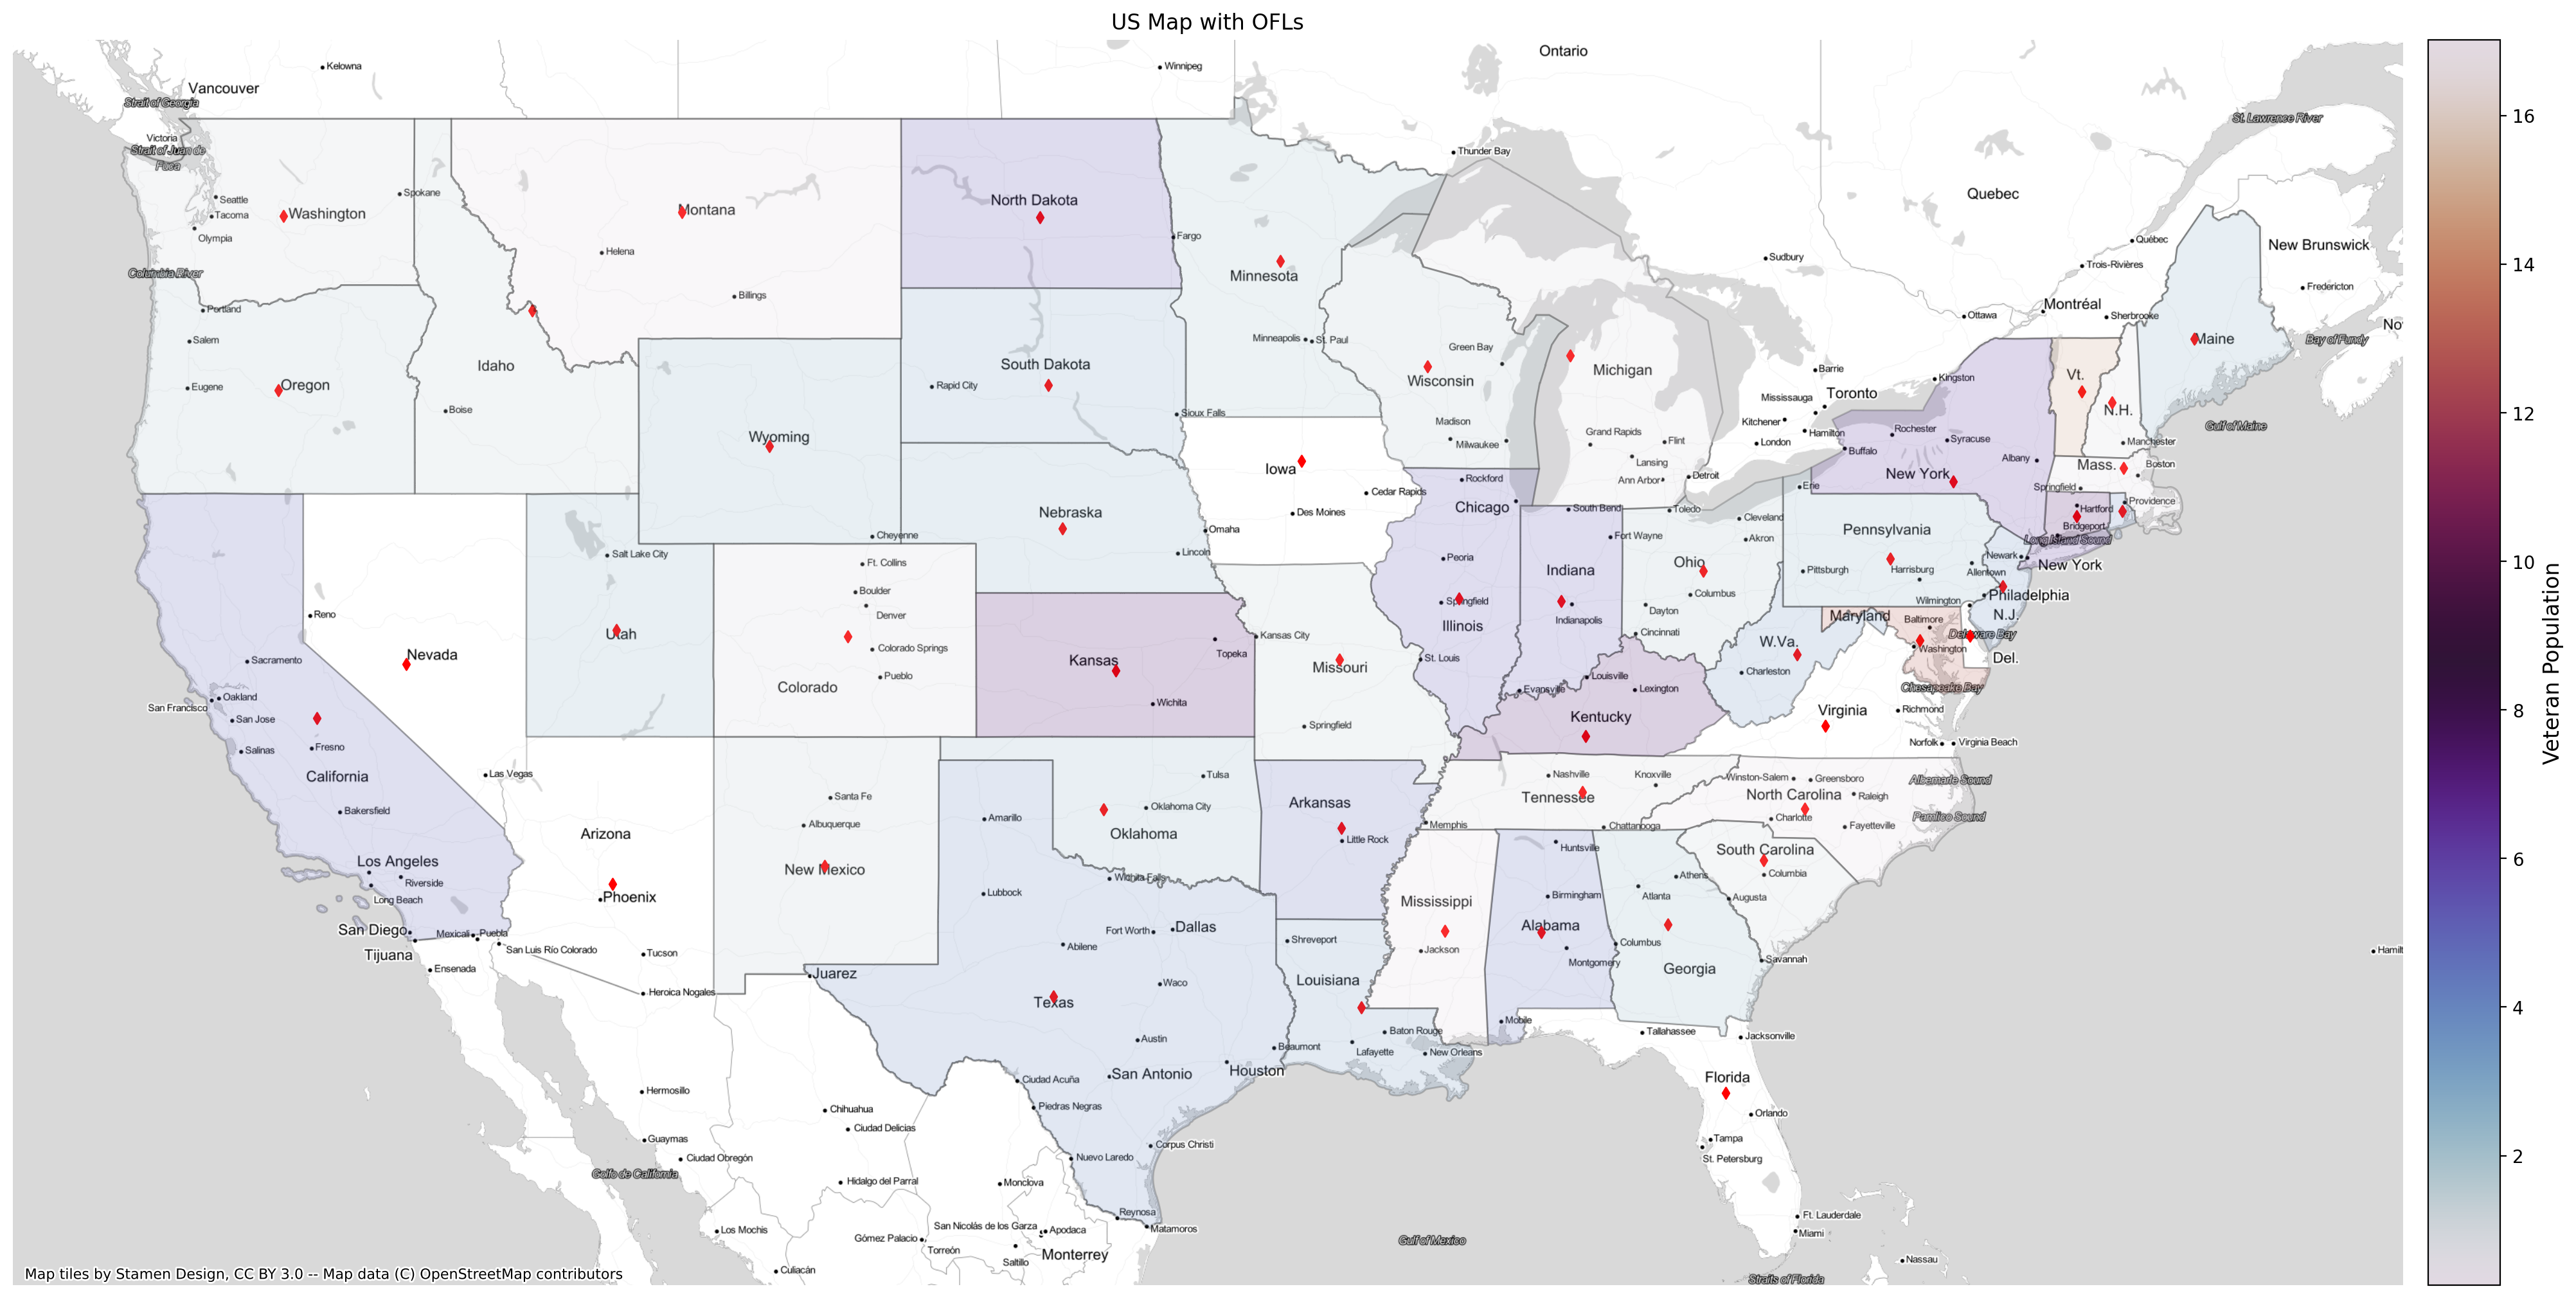

In [55]:


# Plot

from mpl_toolkits.axes_grid1 import make_axes_locatable

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
plt.title('US Map with OFLs',fontsize='large')
plt.scatter(ofls_reduced['LON'], ofls_reduced['LAT'], c = 'r', s=20, marker = 'd')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = us49.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap, alpha = 0.2, legend=True, cax=cax)
ctx.add_basemap(ux, zoom=zoom,source=ctx.providers.Stamen.TonerLite);
plt.ylabel('Veteran Population', fontsize=12)
# Use savefig to save your map
plt.savefig('US Map with OFLS.png')
plt.show()